<a href="https://colab.research.google.com/github/castudil/som-lstm/blob/main/MiniSom/MiniSOm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [4]:
#!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=aa8dbcc859ad1f9a9645fc7aa9acce7c1210e63a19e9b9ff3d3ec1b7b5fffe45
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom


In [231]:
from minisom import MiniSom    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import re

from scipy.spatial.distance import cdist # calcula distancias (cityblock)


# Iris

In [68]:
url='data/iris.csv'
#url='https://raw.githubusercontent.com/piremonte/datasets/master/iris/Iris.csv'
df = pd.read_csv(url, sep=',', decimal=".")
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [70]:
target = df['Species'].astype('category').cat.codes
label_names = {0:'setosa', 1:'versicolor', 2:'virginica'}
data = df[df.columns[1:5]] ## remove categories

# data normalization
#data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data 

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [71]:
data = data.values ### transformar a numpy array
data[1:5,] ## mostrar unos pocos

array([[4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [72]:
data.shape[1] # dimensiones

4

In [73]:
def estimationIteration(som,data, max_iter=1000):
    som_estimation = deepcopy(som)
    q_error = []
    t_error = []

    for i in range(max_iter):
        rand_i = np.random.randint(len(data))
        som_estimation.update(data[rand_i], som_estimation.winner(data[rand_i]), i, max_iter)
        q_error.append(som_estimation.quantization_error(data))
        t_error.append(som_estimation.topographic_error(data))

    plt.plot(np.arange(max_iter), q_error, label='quantization error')
    plt.plot(np.arange(max_iter), t_error, label='topographic error')
    plt.ylabel('error')
    plt.xlabel('iteration index')
    plt.legend()
    plt.show()

In [74]:
# Initialization and training
n_neurons = 10
m_neurons = 10
# initialization and training of 10x10 SOM
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=2, learning_rate=.5,
              activation_distance='euclidean', neighborhood_function='gaussian', random_seed=11)


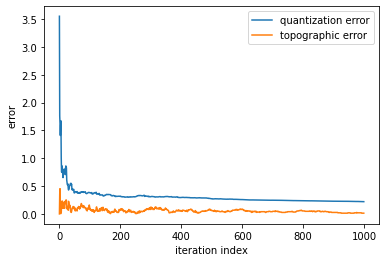

In [56]:
estimationIteration(som, data,max_iter=1000)

In [75]:

som.pca_weights_init(data) ### iniciaclizacion malla usando vectores PCA. fue mejor que inicializar al azar.
som.train(data, 1000, verbose=True)  # random training

som.topographic_error(data)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.22112500730264667


0.02

## Experimento 1

In [76]:
def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return np.sqrt(np.dot(x, x.T))

In [77]:
def perturbation(instance, num_muta=100, mu=0, sigma=0.1):
    """
    Funcion que perturba una columna de un dataframe, con una cantidad 
    normalmente distribuida con media 0 y desviación típica 0,1 por defecto.

    Parameters
        -----------
    instance : np.array
        instancia que será perturbada
    num_muta : int
        cantidad de perturbaciones a generar
    mu: float
        mean
    sigma: float
        desviación estándar
    """
    df =[] # inicia el array 

    cardinality = instance.shape[0] # numero de columnas de la instancia

    # Genera n mutaciones de la instancia dada.
    for i in range(num_muta):
        # Toma muestras aleatorias de una distribución normal
        noise = pd.Series(np.random.normal(loc=mu, scale=sigma, size=cardinality))
        # suma el ruido a las instancia en particular
        element = np.array(instance + noise) 
        # Agrega la instancia perturbada a lista de instancias mutadas
        df.append(element)

    return np.array(df)

In [281]:
#### asi podemos consultar el vector que representa una instancia
ins = 0
print('Instancia ',ins,': ', data[ins])

Instancia  0 :  [5.1 3.5 1.4 0.2]


In [309]:
def promedio_error_acumulado_som(instancia, modelo, num_muta=100, type_error='map'):  ##TODO: ESCRIBIR ALGORITMO
    '''
    
    '''
    # Generación de instancias perturbadas manualmente
    ins_perturbate =perturbation(instancia, num_muta)

    if type_error =='map':
        # 2- Se identifica la neurona que representa a la instancia seleccionada 'x'.
        bmu = [np.asarray(modelo.winner(instancia)).tolist()] # modelo.quantization(np.array([instancia]))[0]

        # 3- Para cada instancia perturbada, se identifica a la neurona que la representa.
        bmu_mutantes = [ [np.asarray(modelo.winner(np.array([ins]))).tolist()] for ins in ins_perturbate]

        #4- Calcula la distancia/error que existe entre la neurona que representa a ´x´ y la neuronas que representa a las mutante.
        distancias = np.array([cdist(bmu, bmu_mutante, metric='cityblock') for bmu_mutante in bmu_mutantes])
    else:
        # 2- Se identifica la neurona que representa a la instancia seleccionada 'x'.
        bmu = modelo.quantization(np.array([instancia]))[0]

        # 3- Para cada instancia perturbada, se identifica a la neurona que la representa.
        bmu_mutantes = [modelo.quantization(np.array([ins]))[0] for ins in ins_perturbate]

        #4- Calcula la distancia/error que existe entre la neurona que representa a ´x´ y la neuronas que representa a las mutante.
        distancias = np.array([fast_norm(bmu-bmu_mutante) for bmu_mutante in bmu_mutantes])

    # 5- Calcula el error acumulado
    error_acum = distancias.sum() / len(ins_perturbate)

    return (error_acum, ins_perturbate)

In [284]:
error, ins_perturbate = promedio_error_acumulado_som(data[ins],som, 100)
error

1.08

Se puede ver en la malla las neuronas que se activaron con los datos perturbados

In [285]:
som.activation_response(ins_perturbate).T

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  5., 21., 19.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 26., 14.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

# graficar perturbacione en malla SOM

* TODO: crear funcion

* TODO: parametro de la funcion que permita ver instancias del dataset en gris con alpha muy bajo

In [293]:
def graph_perturbation_u_matrix(som,instance, ins_perturbate, data=[], show_data=False, col_names=[], show_target=False, jitter=True ,save_img=False, name_image='som_seed_pert'):
    w_x, w_y = zip(*[som.winner(d) for d in ins_perturbate]) ## obtener coordenadas de las perturbaciones
    w_x = np.array(w_x) ## vectores de las columnas de todas las neuronas que representan a las perturbaciones.
    w_y = np.array(w_y) ## idem para filas en la malla SOM

    w_x_ins, w_y_ins = zip(*[som.winner(instance)]) ### coordenadas de la BMU
    w_x_ins = np.array(w_x_ins)
    w_y_ins = np.array(w_y_ins)


    plt.figure(figsize=(10, 10))
    plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
    plt.colorbar()

    colors = ['#0081a7', '#ff70a6', '#a7c957']

    if show_data:
        w_x_data, w_y_data = zip(*[som.winner(d) for d in data]) ## obtener coordenadas de los datos
        w_x_data = np.array(w_x_data) ## vectores de las columnas de todas las neuronas.
        w_y_data = np.array(w_y_data) ## idem para filas en la malla SOM
        if show_target:
            for c in np.unique(target):
                idx_target = target==c
                plt.scatter(w_x_data[idx_target]+(.5+(np.random.rand(np.sum(idx_target))-.5)*.8 if jitter else 0),
                            w_y_data[idx_target]+(.5+(np.random.rand(np.sum(idx_target))-.5)*.8 if jitter else 0), 
                            s=50, c=colors[c], label=label_names[c], alpha=.6)
        else:
            plt.scatter(w_x_data+(.5+(np.random.rand(data.shape[0])-.5)*.6 if jitter else 0),
                    w_y_data+(.5+(np.random.rand(data.shape[0])-.5)*.6 if jitter else 0), 
                    s=50, c='#888888', label="BMU instance", alpha=.3) 

    plt.scatter(w_x+(.5+(np.random.rand(ins_perturbate.shape[0])-.5)*.6 if jitter else 0),
                w_y+(.5+(np.random.rand(ins_perturbate.shape[0])-.5)*.6 if jitter else 0), 
                s=100, c='#ffbd00', label="BMU Perturbed Instances", alpha=.4) ## rand le da un a especie de Jitter para que no aparezcan en el mimos punto
    plt.scatter(w_x_ins+(.5+(np.random.rand(1)-.5)*.6 if jitter else 0),
                w_y_ins+(.5+(np.random.rand(1)-.5)*.6 if jitter else 0), 
                s=150, c='#d00000', label="BMU query instance", alpha=.8) 

    plt.legend(loc='upper right')
    plt.grid()
    if save_img:
        plt.savefig('images/'+str(name_image)+'.png')
    plt.show()

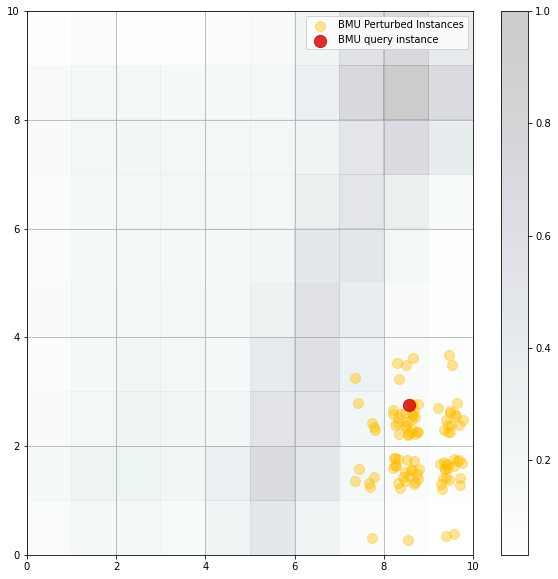

In [289]:
graph_perturbation_u_matrix(som, data[ins], ins_perturbate, jitter=True)

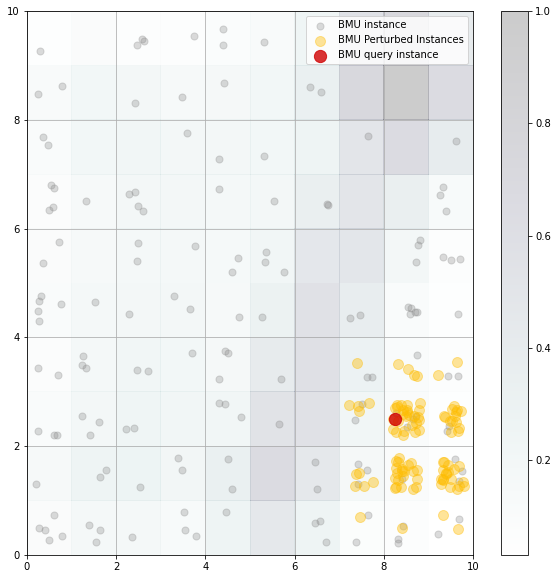

In [294]:
graph_perturbation_u_matrix(som, data[ins], ins_perturbate, data, show_data=True, save_img=True, name_image='inst_pert_gris')

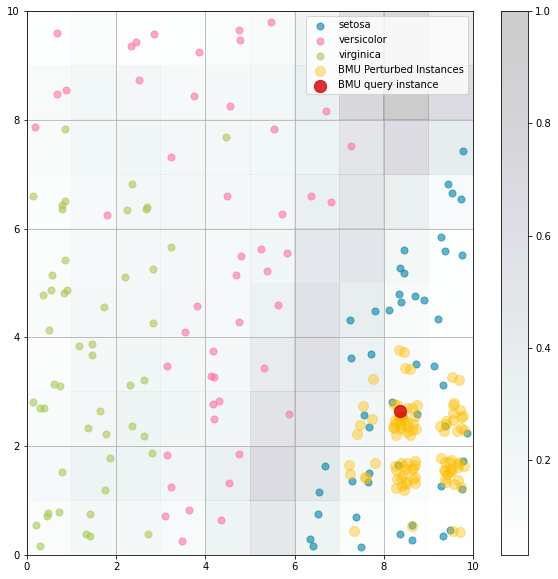

In [295]:
graph_perturbation_u_matrix(som, data[ins], ins_perturbate, data, show_data=True, col_names=target, show_target=True,  save_img=True, name_image='inst_pert_category')

## Gráficas

### TODO: crear una funcion

In [157]:
def graph_category_u_matrix(som, data, target, save_img=False):
    w_x, w_y = zip(*[som.winner(d) for d in data])
    w_x = np.array(w_x)
    w_y = np.array(w_y)

    plt.figure(figsize=(10, 10))
    plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
    plt.colorbar()

    colors = ['C3', 'C2', "C1"]

    for c in np.unique(target):
        idx_target = target==c
        plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                    w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                    s=50, c=colors[c], label=label_names[c])
    plt.legend(loc='upper right')
    plt.grid()
    if save_img:
        plt.savefig('images/som_seed_target.png')
    plt.show()

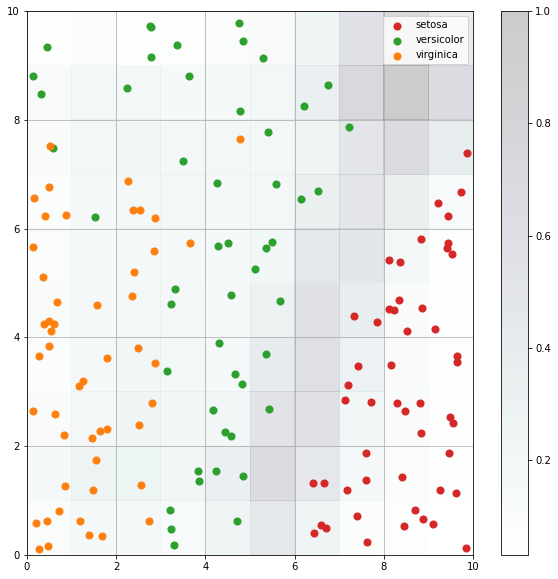

In [211]:
graph_category_u_matrix(som, data, target)

TODO: crear una funcion

Explicar en texto que es lo que hace

In [212]:
def camel_case_split(str): 
    return ' '.join(re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str) )

In [213]:
def graph_weights(som, names_col, num_neurons, save_img=False):
    W = som.get_weights()
    plt.figure(figsize=(13, 10))

    for i, f in enumerate(names_col):
        plt.subplot(2, 2, i+1)
        plt.title(f)
        plt.pcolor(W[:,:,i].T, cmap='coolwarm')
        plt.colorbar()
        plt.xticks(np.arange(num_neurons+1))
        plt.yticks(np.arange(num_neurons+1))
    plt.tight_layout()
    if save_img:
        plt.savefig('images/som_weights.png')
    plt.show()

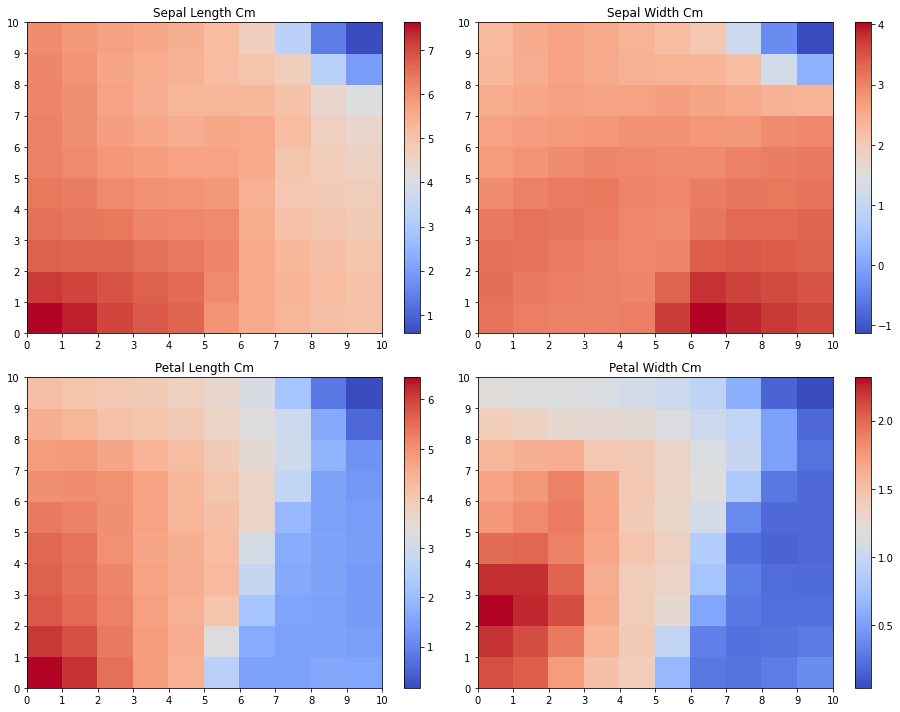

In [143]:

col_names =[(camel_case_split(d)) for d in df.columns[1:5]]
graph_weights(som,col_names, n_neurons, True)

# Instancia 130

In [304]:
ins=130
error, ins_perturbate = promedio_error_acumulado_som(data[ins],som, 100)
error

0.0

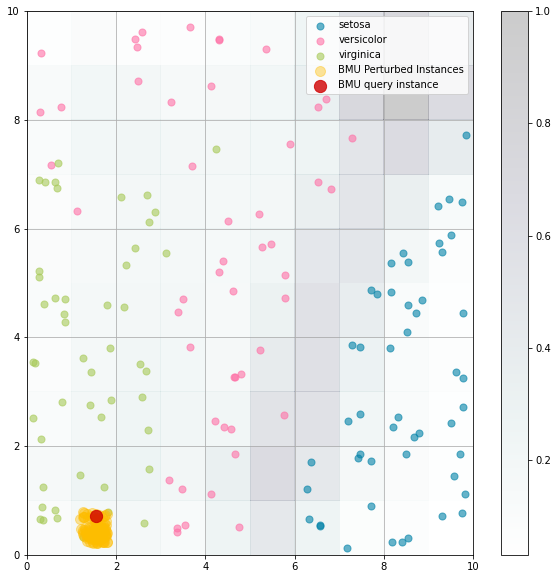

In [305]:
graph_perturbation_u_matrix(som, data[ins], ins_perturbate, data, show_data=True, col_names=target, show_target=True,  save_img=True, name_image='inst_130')

Con la instancia 130 se puede observar una robustez mayor. Al generar instancias perturbadas y obtener su BMU, se obtiene un error 0, es decir, se selecciono la misma neurona para todos los casos, osea que el método puede ver la robustez de las instancias de un conjunto de datos.

# Instancia 90

In [306]:
ins=90
error, ins_perturbate = promedio_error_acumulado_som(data[ins],som, 100)
error

0.79

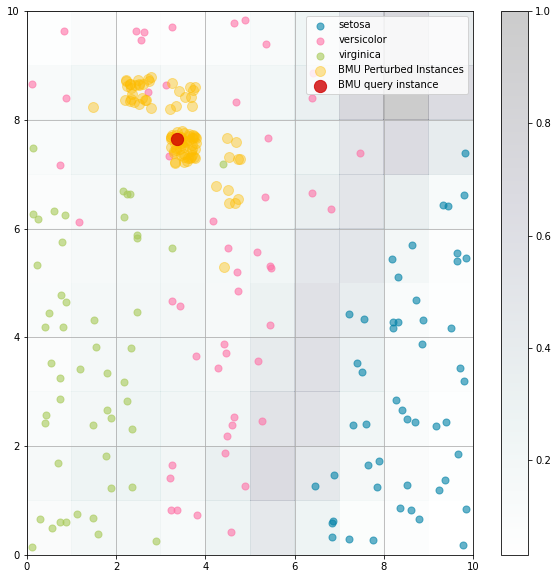

In [308]:
graph_perturbation_u_matrix(som, data[ins], ins_perturbate, data, show_data=True, col_names=target, show_target=True, save_img=True, name_image='inst_90')

Se puede observar que en la instancia 90 en su mayoría las instancias perturbadas pertenecen a la misma clasificación que la seleccionada. Pero existen 6 que quedaron erróneamente clasificadas